In [1]:
import sys
import os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

import numpy as np
import pandas as pd
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.io as pio
from IPython.display import display, clear_output
import ipywidgets as widgets
import pickle

from utils.placecell_functions import *
from utils.placecell_ploting import *
from utils.placecell_classes import data_loader, animal_widgets

In [2]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [3]:
data_dir = "../data/"
save_location = "../output_data/"
output_dir = "../output_figs/"

exp_sets = ['mcherry']
data_sets = ['Day2 - Squ-Tri-Tri','Day4 - Tri-Tri-Tri', 'Day5 - Tri-OptoTri-Tri', 'Day6 - Tri-OptoHex-Hex']

data_titles = ['Day2 - Familiar - Novel - Novel','Day4 - Familiar - Familiar - Familiar', 'Day5 - Familiar - OptoFamiliar - Familiar', 'Day6 - Familiar - OptoNovel - Novel']
session_names = [["Familiar", "Novel", "Novel"],["Familiar", "Familiar", "Familiar"],["Familiar", "OptoFamiliar", "Familiar"],["Familiar", "OptoNovel", "Novel"]]

data_filenames = ['ratemap_structure_day2.mat','ratemap_structure_day4.mat','ratemap_structure_day5.mat','ratemap_structure_day6.mat']


opto_actual_bins = [8, 20] #These are the zones that contained opto frames but the edges hardly had any
control_actual_bins = [21, 33] #This is the oposite of that zone. 
opto_bins = [10,18] # inclusive and based on zero index (added +1 when indexing)
control_bins = [21,29] # inclusive and based on zero index (added +1 to second element when indexing)


# colour palettes used for the plotting
purple_green_pallette = [(0.24423453, 0.20678459, 0.41985299), (0.29215894, 0.76144162, 0.67886578)]
purple_orange_pallette = [(0.24423453, 0.20678459, 0.41985299), (0.9411764705882353, 0.5607843137254902, 0.2901960784313726)]

purple_green_pallette_point = [(0.44423453, 0.40678459, 0.61985299), (0.29215894, 0.76144162, 0.67886578)]
purple_orange_pallette_point = [(0.44423453, 0.40678459, 0.61985299), (0.9490196078431372, 0.6784313725490196, 0.45098039215686275)]


joint_pal = [purple_orange_pallette, purple_green_pallette]
joint_pal_point = [purple_orange_pallette_point, purple_green_pallette_point]


### Define and show widgets
Using ipython widgets create and show widgets for data display option
- Could add observers for each widget to run the data processing step

In [4]:
# callback function to redraw widgets when dataset changes
def update_widgets(change):
    animals.create_widget(output_widget)
    

sort_by = widgets.RadioButtons(
        options=['Session 1', 'Session 2', 'Session 3'],
        index = 1,
        description='Ratemap to align to:',
        disabled=False,
        button_style='info', # 'success', 'info', 'warning', 'danger' or ''
    )

activity_type = widgets.Select(
                options=["All activity","Place activity"],
                index=0,
                rows = 2,
                description='Activity type:',
                disabled=False,
                style= {'description_width': 'initial'}
            )

show_opto = widgets.Checkbox(
            value=False,
            description='Show optozone',
            disabled=False,
            indent=False
        )

ratemap_type = widgets.Select(
                options=["All cell rates","Place cells"],
                index=0,
                rows = 2,
                description='Ratemap type:',
                disabled=False,
                style= {'description_width': 'initial'}
            )


# create an instance of the data loader
data = data_loader(data_dir, exp_sets, data_sets, data_filenames, data_titles, session_names)

# observe when the data object changes
data.data_widget.observe(update_widgets, names = 'value')

#create an output widget that will hold the FOV image or the selection widget
output_widget = widgets.Output() 

#create animals widgets
animals = animal_widgets(output_widget, data)

#display all of the widgets
display(data.exp_widget)
display(data.data_widget)
display(animals.create_widget(output_widget)) 
display(activity_type)
display(ratemap_type)
display(sort_by)
display(show_opto)


RadioButtons(description='Experiments:', options=('mcherry',), value='mcherry')

RadioButtons(description='Dataset:', options=('Day2 - Squ-Tri-Tri', 'Day4 - Tri-Tri-Tri', 'Day5 - Tri-OptoTri-…

Output()

Select(description='Activity type:', options=('All activity', 'Place activity'), rows=2, style=DescriptionStyl…

Select(description='Ratemap type:', options=('All cell rates', 'Place cells'), rows=2, style=DescriptionStyle(…

RadioButtons(description='Ratemap to align to:', index=1, options=('Session 1', 'Session 2', 'Session 3'), val…

Checkbox(value=False, description='Show optozone', indent=False)

### Process the data for plotting

In [11]:
# get widgets values and process data
animal_id = animals.selection.value
ids_to_pool = animals.ids_to_pool.value
sort_by_index = sort_by.index
compare_to_place = activity_type.index
plot_opto = show_opto.value

placecell_rates_dict = data.placecell_rates_dict
placecell_info_dict = data.placecell_info_dict

raw_rates_dict = data.raw_rates_dict
#raw_rates_info_dict = data.allcell_info_dict

sub_titles = data.sub_titles
data_set_to_plot = data.data_set_to_plot
title_for_data = data.title_for_data 
display_placecells = ratemap_type.index


# Select which data to be included in analysis
if animal_id == 'pooled data':
    #concatonate all of the animals ontop of eachother into a list
    placecell_rates = create_pooled_data(placecell_rates_dict,ids_to_pool)
    placecell_spatial_info = create_pooled_data(placecell_info_dict,ids_to_pool)
    raw_rates = create_pooled_data(raw_rates_dict,ids_to_pool)
    rates_average, rates_sem = get_pooled_average_rates(raw_rates_dict,ids_to_pool)
    coors_diags_mean, coors_diags_sem, opto_zone_diag, ctrl_zone_diag, opto_zone_avg, control_zone_avg = get_pooled_avg_corrs(raw_rates_dict,
                                                                                                                              placecell_rates_dict,
                                                                                                                              sort_by_index,
                                                                                                                              compare_to_place,
                                                                                                                              ids_to_pool,
                                                                                                                              opto_bins,
                                                                                                                              control_bins)
else:
    placecell_rates = placecell_rates_dict[animal_id]
    raw_rates = raw_rates_dict[animal_id]
    rates_average = get_average_rates(raw_rates_dict,animal_id)


# sort the ratemaps based on the user input
compare_rates = placecell_rates[sort_by_index]
sort_id, sort_index = sort_ratemaps(compare_rates)

# using the indices of sort_id Sort each placecell and rawrates  DataFrames in the list of dataframes and s and convert 
place_rates_sorted = [df.reindex(sort_id).fillna(0) for df in placecell_rates]
raw_rates_sorted = [df.reindex(sort_id).fillna(0) for df in raw_rates]
spatial_info_sorted = [df.reindex(sort_id).fillna(0) for df in placecell_spatial_info]

#get the placefield center for sorted ratemaps
place_rates_sorted_centers = [get_placecell_centers(df) for df in place_rates_sorted]
raw_rates_sorted_centers = [get_placecell_centers(df) for df in raw_rates_sorted]


# Proccess which rate maps to display          
if compare_to_place:
    display_rates = place_rates_sorted
else:
    display_rates = raw_rates_sorted
    display_rates[sort_by_index] = place_rates_sorted[sort_by_index]

# create the arrays to used for correlation
array1 = display_rates[sort_by_index].values
array2 = [df.values for df in display_rates]

# create the population vector correlation
place_rates_popveccorr = [create_corr_matrix(array1,array2[i]) for i in range(len(array2))]

# create the spatial correlation
place_rates_spatialcorr = [spatial_corr(array1,array2[i]) for i in range(len(array2))]


if animal_id != 'pooled data':

    coors_diags_mean = [np.diagonal(corrs) for corrs in place_rates_popveccorr]
    opto_zone_avg = [[np.mean(corrs[opto_bins[0]:opto_bins[1]+1,opto_bins[0]:opto_bins[1]+1])] for corrs in place_rates_popveccorr]
    control_zone_avg = [[np.mean(corrs[control_bins[0]:control_bins[1]+1,control_bins[0]:control_bins[1]+1])] for corrs in place_rates_popveccorr]

    opto_zone_diag = [[np.nanmean(id[opto_bins[0]:opto_bins[1]+1])] for id in coors_diags_mean]
    ctrl_zone_diag = [[np.nanmean(id[control_bins[0]:control_bins[1]+1])] for id in coors_diags_mean]


if display_placecells:
    rates_to_plot =  sort_placecells(placecell_rates)
else:
    rates_to_plot = display_rates



ctrl_zone_diag_display = ctrl_zone_diag.copy()
ctrl_zone_diag_display.pop(sort_by_index)

opto_zone_diag_display = opto_zone_diag.copy()
opto_zone_diag_display.pop(sort_by_index)




c:\Users\Matt\anaconda3\envs\placecell_processing\Lib\site-packages\numpy\lib\_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\Matt\anaconda3\envs\placecell_processing\Lib\site-packages\numpy\lib\_function_base_impl.py:3000: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


[np.float64(1.0),
 np.float64(1.0),
 np.float64(1.0),
 np.float64(0.9999999999999998)]

### Plot the population coors accross multi experiments
need to load the data for each experiment and do analysis and then append to list. Re run above cells and one below for each expeiment before saving data

In [12]:
try:
    grouped_pop_corr_matrix.append(place_rates_popveccorr)
except:
    grouped_pop_corr_matrix = []
    grouped_pop_corr_matrix.append(place_rates_popveccorr)


save the data

In [13]:
np.save(save_location + 'pop_vectors/mcherry_pop_vector.npy', grouped_pop_corr_matrix)

load the data

In [14]:
grouped_pop_corr_matrix = np.load(save_location + 'pop_vectors/mcherry_pop_vector.npy')

In [21]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

def correlation_matrix_subplot_seaborn(
    data,
    x_label,
    plot_labels,
    title,
    fig_scale = 3.5,
    box_labels = ["Opto", 'Ctrl'],
    font_size = 12,
    plot_zones=None,
    zone_color=["lightblue", "blue"],
    colormap = 'viridis',
    zone_plots=[[8, 20], [21, 33]],
):

    if plot_zones is None:
        plot_zones = np.ones(len(data))

    assert len(zone_plots) == len(
        zone_color
    ), "number of zones does not match number of colors"

    num_plots = len(data)
    num_rows = 2
    num_cols = int(np.ceil(num_plots / 2))

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(fig_scale*num_cols, fig_scale*num_rows), sharey=True, sharex=True)


    # Flatten axes for easier iteration (in case of multiple rows)
    axes = axes.flatten()

    # Find global min and max for consistent color scaling
    vmin1 = min([np.min(d) for d in data[1:3]])
    vmax1 = max([np.max(d) for d in data[1:3]])

    vmin2 = min([np.min(d) for d in data[0:2]])
    vmax2 = max([np.max(d) for d in data[0:2]])

    # or set custom maxes
    vmins = [vmin2, vmin2, vmin2, vmin2]
    vmaxs = [vmax2, vmax2, vmax2, vmax2]

    for i, ax in enumerate(axes):
        sns.heatmap(
            data[i],
            ax=axes[i],
            cmap=colormap,
            vmin=vmins[i],  # Set the common color scale
            vmax=vmaxs[i],
            cbar=False,
            cbar_kws={"shrink": 0.5},
            square=True
        )
        axes[i].set_title(plot_labels[i], fontsize=font_size+3)
        axes[i].tick_params(length = 0, pad = 8)
        axes[i].set_xticks([0,40])
        axes[i].set_xticklabels([0, 110], rotation = 0, fontsize = font_size)
        
        axes[i].set_yticks([0,40])
        axes[i].set_yticklabels([0, 110], rotation = 0, fontsize = font_size)

        if i == 0 or i == 2:
            axes[i].set_ylabel(x_label, fontsize=font_size)
        
        if i == 2 or i == 3:
            axes[i].set_xlabel(x_label, fontsize=font_size)

        # Add plot zones (rectangles) to the heatmap
        if plot_zones[i]:
            for j, zone in enumerate(zone_plots):
                rect = Rectangle(
                    (zone[0], zone[0]),  # (x0, y0)
                    zone[1] - zone[0],   # width
                    zone[1] - zone[0],   # height
                    linewidth=2,
                    edgecolor=zone_color[j],
                    facecolor='none',
                    linestyle='--'
                )
                axes[i].add_patch(rect)
                # Adding the text "opto" for the first rectangle and "ctrl" for the second
                if j == 0:
                    axes[i].text(
                        zone[0]+3,  # Shift left for the text outside
                        zone[0] + zone[1] - zone[0] +2,  # Shift downward for the text outside
                        box_labels[j],
                        fontsize=font_size/2,
                        color=zone_color[j],
                        ha="center",
                        va="center",
                        #fontweight="bold"
                    )
                elif j == 1:
                    axes[i].text(
                        zone[0] + 2,  # Shift left for the text outside
                        zone[0] + zone[1] - zone[0] +2,  # Shift downward for the text outside
                        box_labels[j],
                        fontsize=font_size/2,
                        color=zone_color[j],
                        ha="center",
                        va="center",
                        #fontweight="bold"
                    )



    # Hide any unused axes if the number of plots isn't an exact multiple of 2
    for j in range(num_plots, num_rows * num_cols):
        fig.delaxes(axes[j])

    # Add a single color bar outside the subplots
    cbar_ax = fig.add_axes([0.90, 0.25, 0.03, 0.5])  # Position for the color bar
    norm = plt.Normalize(vmin=vmins[0], vmax=vmaxs[0])
    sm = plt.cm.ScalarMappable(cmap=colormap, norm=norm)
    sm.set_array([])  # Only needed for matplotlib < 3.1
    cbar = fig.colorbar(sm, cax=cbar_ax)

    cbar.set_ticks([vmins[0], vmaxs[0]])
    cbar.set_ticklabels([f'{vmins[0]:.2f}', f'{vmaxs[0]:.2f}'], fontsize = font_size-4)

    # Add title to the color bar along its longest length
    cbar.set_label('Correlation Coefficient', rotation=270, labelpad=0, fontsize=font_size)



    plt.suptitle(title, fontsize=font_size+4)
    plt.tight_layout(rect=[0, 0, 0.9, 1])
    #plt.subplots_adjust(top=0.85)  # Adjust to fit the title better
    return fig, axes


C:\Users\Matt\AppData\Local\Temp\ipykernel_6008\1210041071.py:132: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 1])


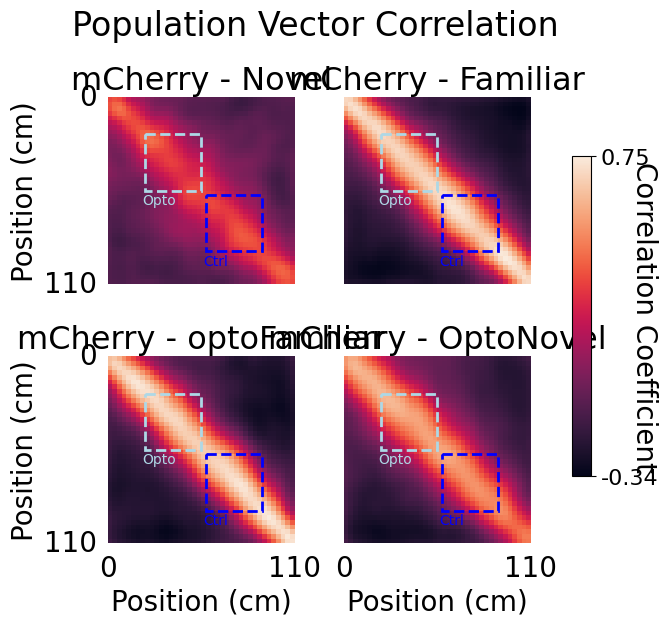

In [22]:
new_data = [grouped_pop_corr_matrix[0], grouped_pop_corr_matrix[1],grouped_pop_corr_matrix[2],grouped_pop_corr_matrix[3]]

session_index = 2

pop_vec_session = [session[session_index] for session in new_data]

plot_labels = ['mCherry - Novel', 'mCherry - Familiar',  'mCherry - optoFamiliar',  'mCherry - OptoNovel']
fig, ax = correlation_matrix_subplot_seaborn(pop_vec_session,"Position (cm)", plot_labels, "Population Vector Correlation", 
                                             font_size=20, fig_scale=3.2,
                                             colormap = 'rocket')

In [24]:
plt.rcParams["font.family"] = "Arial"
plt.rcParams['svg.fonttype'] = 'none'
save_path = f"../output_figs/pop_vector_corr/popvecsmats.svg"
fig.savefig(save_path, format='svg')

# Create group plots from multiple data sets
- run the following cell once to create empty lists and then comment out
- change the dataset via widget and re-run processing and add datasets to list
- plot the resulting grouped plot

In [32]:
# run just once and then comment out
grouped_s3_average_pop_corrs_control = []
grouped_s3_average_pop_corrs_opto = []

In [39]:
# append the data to the grouped data list

grouped_s3_average_pop_corrs_control.append(ctrl_zone_diag_display[1])
grouped_s3_average_pop_corrs_opto.append(opto_zone_diag_display[1])

# reload the next dataset from the widget and reprocess the data. Append the next dataset to the above list

In [43]:
# np.save(save_location + '\\supplement\\mcherry_opto_avg_popvec.npy', grouped_s3_average_pop_corrs_opto)
# np.save(save_location+ '\\supplement\\mcherry_ctrl_avg_popvec.npy', grouped_s3_average_pop_corrs_control)

In [14]:
mcherry_pop_corrs_opto = np.load(save_location + '\\supplement\\mcherry_opto_avg_popvec.npy')
mcherry_pop_corrs_control = np.load(save_location+ '\\supplement\\mcherry_ctrl_avg_popvec.npy')

In [15]:
purple_green_pallette = [(0.24423453, 0.20678459, 0.41985299), (0.29215894, 0.76144162, 0.67886578)]
purple_orange_pallette = [(0.24423453, 0.20678459, 0.41985299), (0.9411764705882353, 0.5607843137254902, 0.2901960784313726)]

purple_green_pallette_point = [(0.44423453, 0.40678459, 0.61985299), (0.29215894, 0.76144162, 0.67886578)]
purple_orange_pallette_point = [(0.44423453, 0.40678459, 0.61985299), (0.9490196078431372, 0.6784313725490196, 0.45098039215686275)]


joint_pal = [purple_green_pallette, purple_orange_pallette]

joint_pal_point = [purple_green_pallette_point, purple_orange_pallette_point]

In [16]:
joint_pal = [['#693ca3', '#3ebec9'], ['#693ca3', '#eb6c9c']]
joint_pal_point = [['#7c5fa3', '#abeff5'], ['#7c5fa3', '#e38dae']]

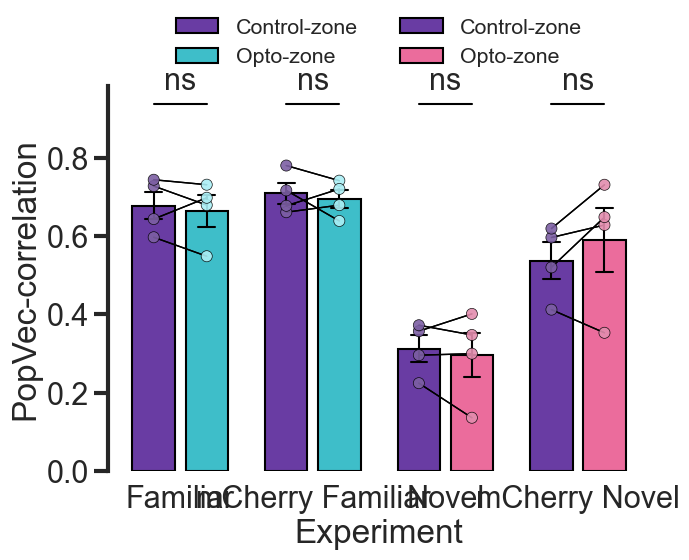

In [17]:
opsins_pop_corrs_opto_nov = mcherry_pop_corrs_opto
opsins_pop_corrs_ctrl_nov = mcherry_pop_corrs_control

def strip_id(id):
    id = str(id)
    animal = id[0:4]
    return animal

y_data_control = opsins_pop_corrs_ctrl_nov
y_data_opto = opsins_pop_corrs_opto_nov


exp_labels = ["Novel", "Familiar", "mCherry Familiar",, "mCherry Novel"]


control_corr_df = pd.DataFrame()
opto_corr_df = pd.DataFrame()
for i in range(len(y_data_control)):
    contorl_temp_df = pd.DataFrame({'PopVec-correlation': pd.Series(y_data_control[i]), 'Experiment': exp_labels[i], 'Zone': 'Control-zone'})
    opto_temp_df = pd.DataFrame({'PopVec-correlation': pd.Series(y_data_opto[i]), 'Experiment': exp_labels[i], 'Zone': 'Opto-zone'})
    control_corr_df = pd.concat([control_corr_df,contorl_temp_df], ignore_index=True)
    opto_corr_df = pd.concat([opto_corr_df,opto_temp_df], ignore_index=True)

pop_corr_melted_df = pd.concat([control_corr_df, opto_corr_df], ignore_index=True)

#pop_corr_melted_df
exp_pvals = []
for exp in exp_labels:
    exp_df = pop_corr_melted_df[pop_corr_melted_df['Experiment'] == exp]
    control_vals = exp_df[exp_df['Zone']=='Control-zone']['PopVec-correlation'].dropna().values
    opto_vals = exp_df[exp_df['Zone']=='Opto-zone']['PopVec-correlation'].dropna().values
    exp_pvals.append(stats.ttest_rel(control_vals,opto_vals)[1])

exp_pval_stars = [get_significance_stars(p_val) for p_val in exp_pvals]

fig = plot_paired_box(pop_corr_melted_df, x = "Experiment", y = "PopVec-correlation", 
                          plot_type = 'barplot',
                          stats = exp_pval_stars, group = "Zone", show_ns=True, fontsize_scale=2.0,
                          width_scale = 1.75, height = 5.0, pallette = joint_pal,
                         point_pallette = joint_pal_point, 
                         point_alpha= 0.9, group_dv=2)



# plt.rcParams["font.family"] = "Arial"
# plt.rcParams['svg.fonttype'] = 'none'
# save_path = f"../output_figs/pop_vector_corr/supplement/mcherry_popvec_correlation.svg"
# fig.savefig(save_path, format='svg')



